Inspired in: https://playground.tensorflow.org/

In [1]:
using Revise
using PyPlot, OCDNN

┌ Info: Precompiling OCDNN [04e95dd8-2660-4c0e-9d70-3f4d10bb3a0d]
└ @ Base loading.jl:1317


In [2]:
dataset = build_dataset(N_samples = 50, N_noise = 0);
data, feat = dataset;

In [3]:
idxs = feat .== 1;
N = sum(idxs);
M = sum(.!idxs);

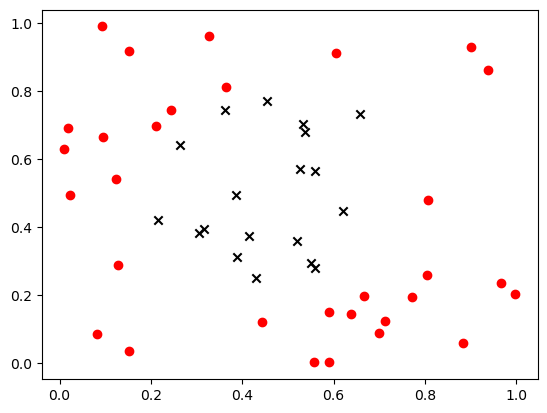

PyObject <matplotlib.collections.PathCollection object at 0x000000005676F4C8>

In [4]:
scatter(data[:,1][idxs],data[:,2][idxs],marker="x", c = "k")
scatter(data[:,1][.!idxs],data[:,2][.!idxs],marker="o", c = "r")

In [18]:
nlayers = 6
channels = 2
niter = 20000
τ=0.1;
τ_max=10;
stepsize = 0.1;

In [19]:
A_eu = 0;
w_eu = 1;
A_ie = [0 0; 1 0];
w_ie = [0.5 ;0.5];
A_kutta4 = [0 0 0 0;0.5 0 0 0;0 0.5 0 0;0 0 1 0];
w_kutta4 = 1/6*[1;2;2;1];
A_kutta3 = [0 0 0;1/2 0 0;-1 2 0];
w_kutta3 = [1/6;2/3;1/6];

In [20]:
rk4 = OCDNN.ExplicitRungeKutta(A_kutta4,w_kutta4,"RK4");
rk2 = OCDNN.ExplicitRungeKutta(A_ie,w_ie,"RK2");

In [21]:
eta = x -> exp(x)/(exp(x)+1)

#5 (generic function with 1 method)

In [22]:
problem = OCDNN.Problem(tanh, eta, feat);
Ctrls = OCDNN.ControlDef(dataset, stepsize, channels, nlayers);

In [23]:
@time Ctrls,F,Fn = train_ode_dnn(dataset, nlayers, channels, rk4, niter, τ, τ_max, stepsize, problem);


Method=RK4, nlayers=6
Iteration no: 1
Value of alpha:  0.1000
Residual:   8.7020
Norm Grad: 4.3804e+00

Method=RK4, nlayers=6
Iteration no: 2000
Value of alpha:  1.2500
Residual:   0.5924
Norm Grad: 1.7042e-02

Method=RK4, nlayers=6
Iteration no: 4000
Value of alpha: 10.0000
Residual:   0.5049
Norm Grad: 5.1750e-04

Method=RK4, nlayers=6
Iteration no: 6000
Value of alpha: 10.0000
Residual:   0.5023
Norm Grad: 2.4939e-04

Method=RK4, nlayers=6
Iteration no: 8000
Value of alpha: 10.0000
Residual:   0.5015
Norm Grad: 1.6515e-04

Method=RK4, nlayers=6
Iteration no: 10000
Value of alpha: 10.0000
Residual:   0.5011
Norm Grad: 1.2338e-04

Method=RK4, nlayers=6
Iteration no: 12000
Value of alpha: 10.0000
Residual:   0.5008
Norm Grad: 9.6965e-05

Method=RK4, nlayers=6
Iteration no: 14000
Value of alpha: 10.0000
Residual:   0.5007
Norm Grad: 7.8592e-05

Method=RK4, nlayers=6
Iteration no: 16000
Value of alpha: 10.0000
Residual:   0.5006
Norm Grad: 6.5855e-05

Method=RK4, nlayers=6
Iteration no:

In [24]:
Ctrls_test = deepcopy(Ctrls);

In [25]:
xs = collect(0:0.01:1)
ys = collect(0:0.01:1);

In [26]:
Y0_test = [[x,y] for x in xs, y in ys];

In [27]:
Ctrls_test.Y0 = hcat(Y0_test...)';

In [28]:
S = OCDNN.RKforwardstepper(Ctrls_test,rk4,problem);

In [29]:
value = reshape(round.(S.Classifier), size(Y0_test))';

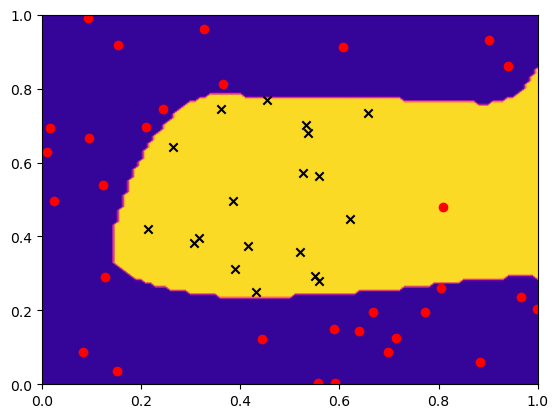

PyObject <matplotlib.collections.PathCollection object at 0x00000000203D68C8>

In [30]:
contourf(xs,ys, value, cmap = "plasma")
scatter(data[:,1][idxs],data[:,2][idxs],marker="x", c = "k")
scatter(data[:,1][.!idxs],data[:,2][.!idxs],marker="o", c = "r")